<a href="https://colab.research.google.com/github/suzy97/HYU_AI2/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__) # 2.4.1

import numpy as np
import os

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0


In [3]:
BATCH_SIZE = 128 #64에서 128로 변경
SHUFFLE_BUFFER_SIZE = 100
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CLASSES = 10
CHANNELS = 3

In [4]:
from keras.datasets import cifar10

def generate_datasets():
  (X_train, y_train), (X_test, y_test) = cifar10.load_data() # cifar 10 데이터셋 로드
  X_test, y_test = resize_and_rescale(X_test, y_test)
  X_train, y_train = augment(X_train, y_train)
  return X_train, y_train, X_test, y_test

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  if os.path.exists('pixel_mean_value.npy'):
    mean_image = np.load('pixel_mean_value.npy')
  else:
    mean_image = np.mean(image, axis=0)
  image -= mean_image
  image = (image / 128.0)
  return image, label

def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 4 pixels of padding
  image = tf.map_fn(lambda img: tf.image.resize_with_crop_or_pad(img, IMAGE_WIDTH + 4, IMAGE_HEIGHT + 4), image)
   # Random crop back to the original size
  image = tf.map_fn(lambda img: tf.image.random_crop(img, size=[IMAGE_WIDTH, IMAGE_HEIGHT, 3]), image)
  image = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), image)
  return image, label

In [5]:
class BasicBlock(tf.keras.layers.Layer):
  def __init__(self, filter_num, stride=1):
    super(BasicBlock, self).__init__()
    initializer = tf.keras.initializers.HeNormal()
    l2 = tf.keras.regularizers.l2(0.0001)
    self.conv1 = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3,3), strides=stride, padding='same', kernel_regularizer=l2, kernel_initializer=initializer)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=l2, kernel_initializer=initializer)
    self.bn2 = tf.keras.layers.BatchNormalization()
    if stride != 1:
      self.downsample = tf.keras.Sequential()
      self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(1,1), strides=stride, kernel_regularizer=l2, kernel_initializer=initializer))
      self.downsample.add(tf.keras.layers.BatchNormalization())
    else:
      self.downsample = lambda x: x

  def call(self, inputs, **kwargs):
    residual = self.downsample(inputs)

    x = self.conv1(inputs)
    x = self.bn1(x)
    x = tf.nn.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)

    output = tf.nn.relu(tf.keras.layers.add([residual, x]))

    return output


def make_basic_block_layer(filter_num, blocks, stride=1):
  res_block = tf.keras.Sequential()
  res_block.add(BasicBlock(filter_num, stride=stride))

  for _ in range(1, blocks):
    res_block.add(BasicBlock(filter_num, stride=1))

  return res_block


class ResNet(tf.keras.Model):
  def __init__(self, layer_params):
    super(ResNet, self).__init__()
    initializer = tf.keras.initializers.HeNormal()
    l2 = tf.keras.regularizers.l2(0.0001)
    self.conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding='same', kernel_regularizer=l2, kernel_initializer=initializer)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.layer1 = make_basic_block_layer(filter_num=16, blocks=layer_params[0], stride=2)
    self.layer2 = make_basic_block_layer(filter_num=32, blocks=layer_params[1], stride=2)
    self.layer3 = make_basic_block_layer(filter_num=64, blocks=layer_params[2], stride=2)
    #self.layer4 = make_basic_block_layer(filter_num=64, blocks=layer_params[3], stride=2) #임의로 추가
    self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
    self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_regularizer=l2, kernel_initializer=initializer)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = tf.nn.relu(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    #x = self.layer4(x)
    x = self.avgpool(x)
    output = self.fc(x)

    return output

def get_model():
  model = ResNet(layer_params=[3, 3, 3])
  model.build(input_shape=(None, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=False), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [6]:
X_train, y_train, X_test, y_test = generate_datasets()

In [7]:
print('train input shape: ', X_train.shape)
print('test input shape: ', X_test.shape)
print('train output shape: ', y_train.shape)
print('train oupput shape: ', y_train.shape)

train input shape:  (50000, 32, 32, 3)
test input shape:  (10000, 32, 32, 3)
train output shape:  (50000, 1)
train oupput shape:  (50000, 1)


In [8]:
model = get_model()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  448       
                                                                 
 batch_normalization (Batch  multiple                  64        
 Normalization)                                                  
                                                                 
 sequential (Sequential)     (None, 16, 16, 16)        14640     
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 32)          52320     
                                                                 
 sequential_4 (Sequential)   (None, 4, 4, 64)          207040    
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                   

In [10]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')

history = model.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=BATCH_SIZE, callbacks=[lr_schedule, early_stopping]) #epoch 를 180 에서 5로 조정

Epoch 1/20
352/352 [==============================] - 8s 22ms/step - loss: 1.0371 - accuracy: 0.6876 - val_loss: 1.3198 - val_accuracy: 0.6022 - lr: 0.0100
Epoch 2/20
352/352 [==============================] - 6s 17ms/step - loss: 0.9663 - accuracy: 0.7135 - val_loss: 1.2450 - val_accuracy: 0.6236 - lr: 0.0100
Epoch 3/20
352/352 [==============================] - 7s 20ms/step - loss: 0.9031 - accuracy: 0.7384 - val_loss: 1.2657 - val_accuracy: 0.6340 - lr: 0.0100
Epoch 4/20
352/352 [==============================] - 7s 19ms/step - loss: 0.8342 - accuracy: 0.7619 - val_loss: 1.2920 - val_accuracy: 0.6356 - lr: 0.0100
Epoch 5/20
352/352 [==============================] - 6s 18ms/step - loss: 0.6494 - accuracy: 0.8370 - val_loss: 1.1099 - val_accuracy: 0.6828 - lr: 0.0010
Epoch 6/20
352/352 [==============================] - 7s 19ms/step - loss: 0.5670 - accuracy: 0.8710 - val_loss: 1.1297 - val_accuracy: 0.6828 - lr: 0.0010
Epoch 7/20
352/352 [==============================] - 6s 18ms/st

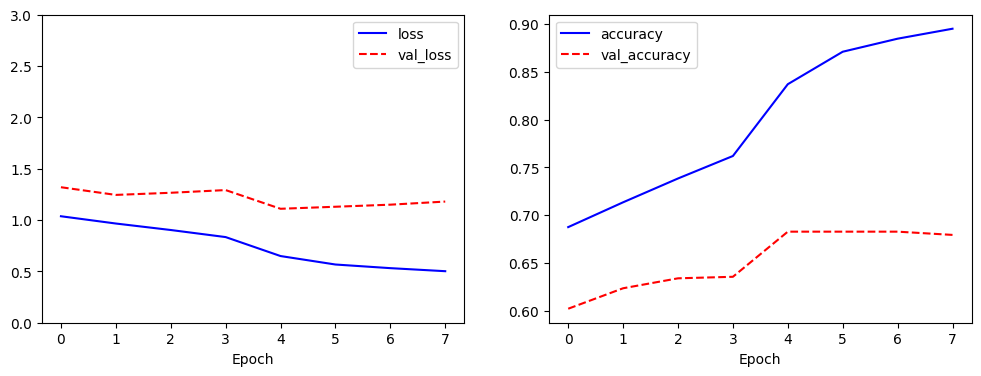

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [12]:
model.evaluate(X_test, y_test, verbose=0) # [loss, accuracy]

[1.1826999187469482, 0.6783999800682068]

In [13]:
# 모델 다운로드
model.save_weights('ResNet_20.h5') # 모델을 코랩에 저장

from google.colab import files
files.download('ResNet_20.h5')# 코랩에 저장된 모델을 로컬로 다운로드

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>